# Running linear models on DEA indices

**Background:** This document presents an example of applying a linear model to analyse Landsat data extracted from Digital Earth Australia (DEA) to make inferences about physical processes. Here we are testing the rate of decline in vegetation condition during the dry season in NW Australia. Rainfall in this part of Australia is highly seasonal. During the dry season (April to October) there is very little rain and we assume that soil moisture declines throughout.

A common approach for assessing the likelihood of vegetation being dependent on groundwater is applying the 'green island' principle. This involves inferring gorudnwater use from vegetation that maintains higher condition during dry periods. In our area of interest, we expect that vegetation condition will decline much more rapidly in vegetation communities that are wholly reliant on surface water compared to communities that access groundwater (i.e. groundwater dependent ecosystems). We use NDVI as a proxy for vegetation condition.


**What does this document do?**

- Retrieve Landsat data for temporal and spatial extents
- Calculate NDVI and groupby months
- Demonstrate how to build a linear model to analyse the rate of decay in NDVI throughout the dry season
- Plot linear model parameters and use spatial patterns to infer distribuition of potential GDEs

**Requirements**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date**: June 2019

**Authors**: Neil Symington, Robbi Bishop-Taylor, Bex Dunn

## Retrieving Landsat data
Here we import data Landsat data from the DEA. In our experience using the larger number of observations decreases our signal-to-noise ration and thus enables us to resolve landscape features at a higher resolution. Hence, for the actual data product we used the entire landsat archive and ran the processing through the raijin supercomputer.  However for this example we will only consider data from 2009-2019 from landsat 8.

### Import modules

In [2]:
%matplotlib inline
import sys
import warnings
import datacube
import matplotlib.pyplot as plt
from datacube.storage import masking
import calendar
import numpy as np
import xarray as xr
from datacube.helpers import write_geotiff

sys.path.append('/g/data/zk34/pxk547/dea-notebooks/10_Scripts/')
import DEADataHandling, DEAPlotting

# Dictoinary for mapping month number to months names 
mnths =dict((k,v) for k,v in enumerate(calendar.month_name) if k!= 0)


In [3]:
# Connect to a datacube
dc = datacube.Datacube(app='LinearModels')


In [11]:
# Create spatial and temporal query


query = {'lat': (-19.5, -20.2),
         'lon': (145.0, 145.5),
         'time':('2019-01-11', '2019-03-01')}  ##these coords worked

#query = {'lat': (-19.5, -20.2),
#         'lon': (145.0, 145.5),
#         'time':('2019-01-11', '2019-03-01')}   ##these coords worked - West section

#query = {'lat': (-19.5, -20.2),
#         'lon': (145.5, 146.1),
#         'time':('2019-01-11', '2019-03-01')}   ##these coords worked - East section

# Define query coordinate reference system
query['crs'] = 'EPSG:4326'
query['output_crs'] = 'EPSG:28355'
query['resolution'] = (25.,25.)


In [12]:
# Load data for the specified query extent using `dc.load`:
bands_of_interest = ['nbar_blue', 
                     'nbar_green', 
                     'nbar_red', 
                     'nbar_red_edge_1',
                     'nbar_red_edge_2',
                     'nbar_nir_1',
                     'nbar_nir_2',
                     'nbar_swir_2',
                     'nbar_swir_3'
                    ]
ds = dc.load(product='s2a_ard_granule', group_by='solar_day', 
                  measurements = bands_of_interest, **query)
ds

<xarray.Dataset>
Dimensions:          (time: 10, x: 2128, y: 3122)
Coordinates:
  * time             (time) datetime64[ns] 2019-01-14T00:27:01.024000 ... 2019-02-26T00:37:01.025000
  * y                (y) float64 7.765e+06 7.765e+06 ... 7.843e+06 7.843e+06
  * x                (x) float64 2.901e+05 2.901e+05 ... 3.433e+05 3.433e+05
Data variables:
    nbar_blue        (time, y, x) int16 2859 2884 2929 2958 ... -999 -999 -999
    nbar_green       (time, y, x) int16 2953 2921 2893 2922 ... -999 -999 -999
    nbar_red         (time, y, x) int16 3042 3039 3048 3034 ... -999 -999 -999
    nbar_red_edge_1  (time, y, x) int16 3535 3540 3455 3477 ... -999 -999 -999
    nbar_red_edge_2  (time, y, x) int16 3756 3766 3661 3655 ... -999 -999 -999
    nbar_nir_1       (time, y, x) int16 4251 4263 4212 4213 ... -999 -999 -999
    nbar_nir_2       (time, y, x) int16 4181 4109 4023 3978 ... -999 -999 -999
    nbar_swir_2      (time, y, x) int16 3935 3905 3806 3805 ... -999 -999 -999
    nbar_swir_3      (time, y, x) int16 2927 2911 2786 2770 ... -999 -999 -999
Attributes:
    crs:      EPSG:28355

In [13]:
#set cloudmasking threshold and load landsat nbart data
#landsat_masked_prop = 0.90
ClearSentinel_ds = DEADataHandling.load_clearsentinel2(dc=dc, query=query, bands_of_interest=bands_of_interest, masked_prop=0.9,mask_pixel_quality=True)
ClearSentinel_ds

Loading s2a pixel quality
    Loading 1 filtered s2a timesteps
Loading s2b pixel quality
    Loading 0 filtered s2b timesteps
Combining and sorting s2a, s2b data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


<xarray.Dataset>
Dimensions:          (time: 1, x: 2128, y: 3122)
Coordinates:
  * y                (y) float64 7.765e+06 7.765e+06 ... 7.843e+06 7.843e+06
  * x                (x) float64 2.901e+05 2.901e+05 ... 3.433e+05 3.433e+05
  * time             (time) datetime64[ns] 2019-02-13T00:26:21.024000
Data variables:
    nbar_blue        (time, y, x) float64 378.0 424.0 407.0 ... 460.0 424.0
    nbar_green       (time, y, x) float64 673.0 724.0 653.0 ... 716.0 684.0
    nbar_red         (time, y, x) float64 649.0 607.0 603.0 ... 839.0 722.0
    nbar_red_edge_1  (time, y, x) float64 1.149e+03 1.087e+03 ... 1.192e+03
    nbar_red_edge_2  (time, y, x) float64 2.029e+03 2.067e+03 ... 1.73e+03
    nbar_nir_1       (time, y, x) float64 2.416e+03 2.797e+03 ... 2.123e+03
    nbar_nir_2       (time, y, x) float64 2.658e+03 2.757e+03 ... 2.299e+03
    nbar_swir_2      (time, y, x) float64 2.594e+03 2.497e+03 ... 2.648e+03
    nbar_swir_3      (time, y, x) float64 1.594e+03 1.502e+03 ... 1.616e+03
    data_perc        (time, y, x) float64 0.9999 0.9999 0.9999 ... 0.9999 0.9999
Attributes:
    crs:      EPSG:28355

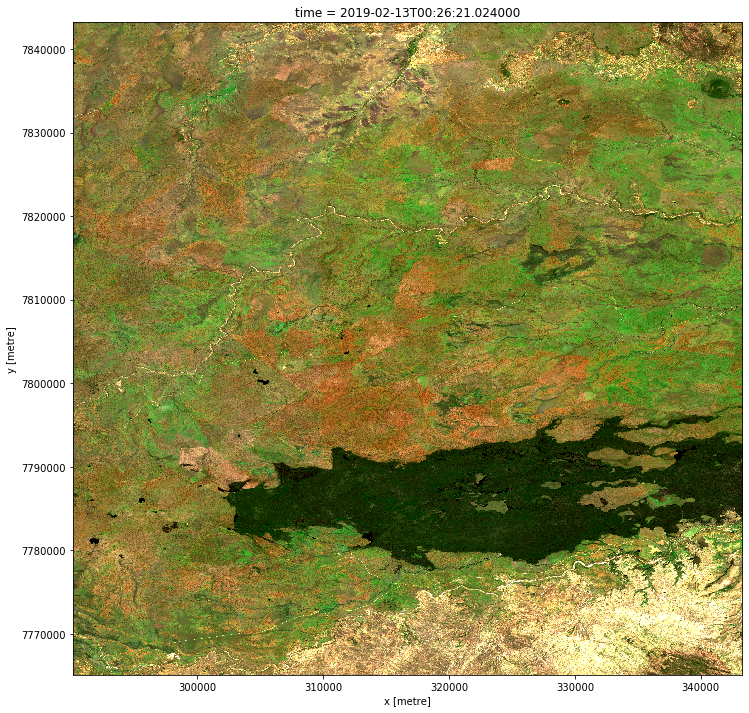

In [14]:
ds[['nbar_red','nbar_green','nbar_blue' ]].isel(time=6).to_array().plot.imshow(robust=True, figsize=(12,12))
#time = 3 for West section; time =6 for East section
#ClearSentinel_ds[['nbar_blue','nbar_green', 'nbar_red']].isel(time=5).to_array().plot.imshow(robust=True, figsize=(12,12))

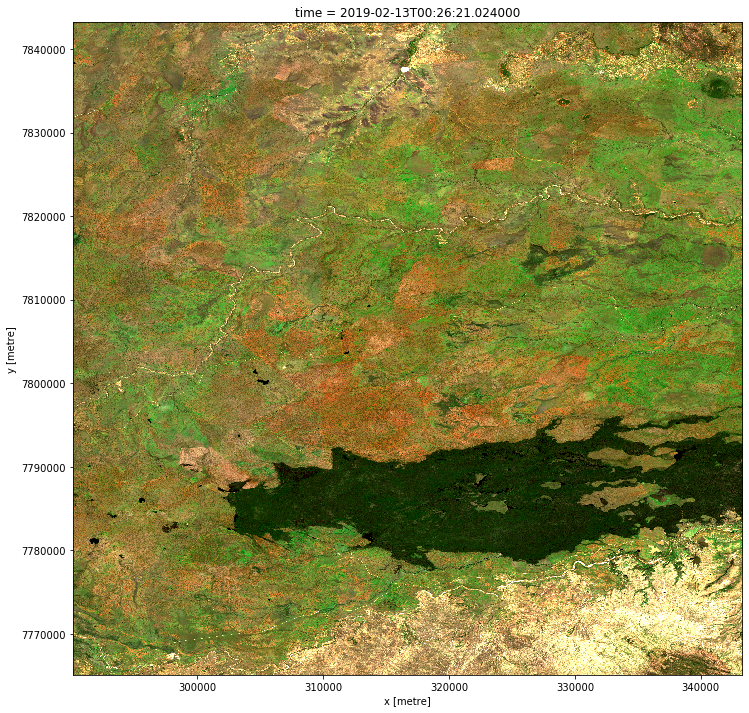

In [24]:
#ds[['nbar_blue','nbar_green', 'nbar_red']].isel(time=5).to_array().plot.imshow(robust=True, figsize=(12,12))
ClearSentinel_ds[['nbar_red','nbar_green','nbar_blue' ]].isel(time=0).to_array().plot.imshow(robust=True, figsize=(12,12))
#time = 0 for east section; time = 0 for west section

In [68]:
# Load data for the specified query extent using `dc.load`:
#LANDSAT 7 gives best cloud free image at time of surface water with flood - 2019-02-10
ds8 = dc.load(product='ls8_nbar_albers', group_by='solar_day', **query
            )
ds8

<xarray.Dataset>
Dimensions:          (time: 3, x: 2534, y: 2763)
Coordinates:
  * time             (time) datetime64[ns] 2019-01-17T00:16:38 ... 2019-02-18T00:16:32
  * y                (y) float64 7.775e+06 7.775e+06 ... 7.844e+06 7.844e+06
  * x                (x) float64 3.426e+05 3.426e+05 ... 4.059e+05 4.059e+05
Data variables:
    coastal_aerosol  (time, y, x) int16 1021 976 1032 1019 ... 1474 1878 2116
    blue             (time, y, x) int16 1003 952 1013 1008 ... 1363 1782 2005
    green            (time, y, x) int16 1268 1219 1262 1220 ... 1622 1962 2247
    red              (time, y, x) int16 1505 1446 1530 1479 ... 1608 1942 2259
    nir              (time, y, x) int16 2808 2748 2860 2887 ... 2905 3279 3609
    swir1            (time, y, x) int16 3326 3221 3281 3291 ... 2739 3077 3432
    swir2            (time, y, x) int16 2565 2478 2531 2500 ... 1855 2211 2504
Attributes:
    crs:      EPSG:28355

In [69]:
# Load data for the specified query extent using `dc.load`:
#LANDSAT 7 gives best cloud free image at time of surface water with flood - 2019-02-10
ds7 = dc.load(product='ls7_nbar_albers', group_by='solar_day', **query
            )
ds7

<xarray.Dataset>
Dimensions:  (time: 2, x: 2534, y: 2763)
Coordinates:
  * time     (time) datetime64[ns] 2019-02-10T00:10:47 2019-02-26T00:10:18
  * y        (y) float64 7.775e+06 7.775e+06 7.775e+06 ... 7.844e+06 7.844e+06
  * x        (x) float64 3.426e+05 3.426e+05 3.426e+05 ... 4.059e+05 4.059e+05
Data variables:
    blue     (time, y, x) int16 478 512 512 545 512 ... -999 -999 -999 -999 -999
    green    (time, y, x) int16 714 767 820 767 767 ... -999 -999 -999 -999 -999
    red      (time, y, x) int16 830 923 970 908 892 ... -999 -999 -999 -999 -999
    nir      (time, y, x) int16 2265 2341 2417 2379 2341 ... -999 -999 -999 -999
    swir1    (time, y, x) int16 2254 2381 2424 2296 2296 ... -999 -999 -999 -999
    swir2    (time, y, x) int16 1339 1451 1541 1451 1272 ... -999 -999 -999 -999
Attributes:
    crs:      EPSG:28355

## Adding code in to extract cloud free data only (from Bex's stacked plot script)

In [70]:
#set cloudmasking threshold and load landsat nbart data
landsat_masked_prop = 0.90
ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',
        masked_prop=landsat_masked_prop)

### ARE NO CLEAR IMAGES IN THIS DATASET FOR DATES NEEDED FOR SCOTT - THINK LS7 NOT INCLUDED DUE TO STRIPINESS
#to load more than just landsat 8:
#ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',masked_prop=landsat_masked_prop)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 0 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float32)


In [71]:
# Set all nodata pixels to `NaN`:  DON"T NEED THIS IF USING DEADataHandling as does it within code there
#ds = masking.mask_invalid_data(ds)
ls578_ds

<xarray.Dataset>
Dimensions:          (time: 0, x: 2534, y: 2763)
Coordinates:
  * time             (time) datetime64[ns] 
  * y                (y) float64 7.775e+06 7.775e+06 ... 7.844e+06 7.844e+06
  * x                (x) float64 3.426e+05 3.426e+05 ... 4.059e+05 4.059e+05
Data variables:
    coastal_aerosol  (time, y, x) float32 
    blue             (time, y, x) float32 
    green            (time, y, x) float32 
    red              (time, y, x) float32 
    nir              (time, y, x) float32 
    swir1            (time, y, x) float32 
    swir2            (time, y, x) float32 
    data_perc        (time, y, x) float32 
Attributes:
    crs:      EPSG:28355

In [72]:
# View the rgb imagetime64[ns] 2019-01-17T00:17:02 ... 2019-02-18T00:16:56time64[ns] 2019-01-17T00:17:02 ... 2019-02-18T00:16:56

ls578_ds[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(robust=True, figsize=(6,6))

#Neils original code: (which doesn't take out cloud)
#ds[['red', 'green', 'blue']].isel(time=1).to_array().plot.imshow(robust=True, figsize=(6,6))


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:

### TIME = 0 - Feb image; compare with time = 3 for April image when drier (but still green)
ds7[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(robust=True, figsize=(15,11))



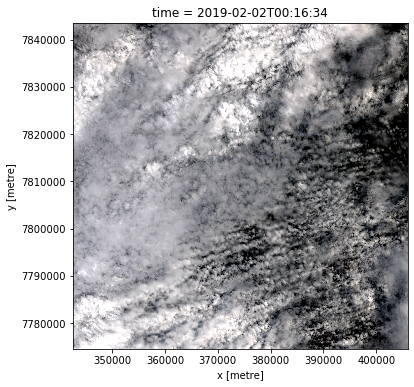

In [76]:
# View the rgb image

ds8[['red', 'green', 'blue']].isel(time=2).to_array().plot.imshow(robust=True, figsize=(6,6))

#Neils original code: (which doesn't take out cloud)
#ds[['red', 'green', 'blue']].isel(time=1).to_array().plot.imshow(robust=True, figsize=(6,6))


In [22]:
#set variable to insert date of image automatically into fileneam
######CHECK TIME VARIABLE IS CORRECT - NEED TO MANUALLY SET##############
#Datels578 = str(ls578_ds.isel(time=0).time.values)[0:10]
#Datels7 = str(ds7.isel(time=0).time.values)[0:10]
#Datels8 = str(ds8.isel(time=0).time.values)[0:10]
DateSentinelClr = str(ClearSentinel_ds.isel(time=0).time.values)[0:10]
DateSentinel = str(ds.isel(time=6).time.values)[0:10]

In [52]:
#swrite landsat 578 dataset
write_geotiff('/g/data/zk34/pxk547/landsat_scripts/NullaLS8_E_Scott'+Datels578[0:10]+'.tif',ls578_ds.isel(time=0))


In [25]:
#swrite clear entinel dataset
write_geotiff('/g/data/zk34/pxk547/landsat_scripts/NullaSentinelClrW_Scott'+DateSentinelClr[0:10]+'.tif',ClearSentinel_ds.isel(time=0))

In [ ]:
#set dataset equal to landsat 8 dataset
write_geotiff('/g/data/zk34/pxk547/landsat_scripts/NullaLS8_E_Scott'+Dateds8[0:10]+'.tif',ls8_ds.isel(time=0))

In [23]:
#write sentinel dataset
write_geotiff('/g/data/zk34/pxk547/landsat_scripts/NullaSentinelW_Scott'+DateSentinel[0:10]+'.tif',ds.isel(time=6))